# Example of Dicom de-identification using CleverDoc

![apicom.pro](https://apicom.pro/static/logo-small-borderless.8f68168a2b0e.png)

### Install CleverDoc package

In [ ]:
%pip install -U cleverdoc[inference-gpu]

### Start Spark Session with CleverDoc

For get Trial license please contact to email: [license@apicom.pro](license@apicom.pro)

In [2]:
license = "your_license_here"

from cleverdoc import *
spark = start(license)
spark

Spark version: 3.4.2
CleverDoc version: 1.0.8


## Define CleverDoc pipeline

In [3]:
import importlib.resources
from pyspark.ml.pipeline import PipelineModel
import pyspark.sql.functions as f

dicom = DicomToImage() \
    .setInputCols(["content"]) \
    .setOutputCol("image") \
    .setKeepInput(True)

image_to_string = ImageToStringOnnx()

ner = Ner() \
    .setModel("ApicomPro/deid-bert-onnx-1.2.0") \
    .setNumPartitions(0) \
    .setThreshold(0.8) \
    .setDevice(Device.CPU.value)

draw_regions = DicomDrawBoxes() \
    .setInputCols(["content", "ner"]) \
    .setOutputCol("dicom") \
    .setAggCols(["path", "content"]) \
    .setKeepInput(True) \
    .setCompression(DicomCompression.RLELossless) \
    .setForceCompress(False)


def pipeline(debug=False):
    stages=[
        dicom,
        image_to_string,
        ner
    ]
    if not debug:
        stages.append(draw_regions)
    return PipelineModel(stages)


License uid: a6e80c86-204a-11ef-976d-0242ac130004
License expiration date: 2025-06-02 01:59:59


## Load example DICOM file from resources

In [4]:
dicom_example = importlib.resources.files('cleverdoc').joinpath('resources/dicoms/dicom-1.dcm').as_posix()

df = spark.read.format("binaryFile") \
    .load(dicom_example)

## Display pixel data

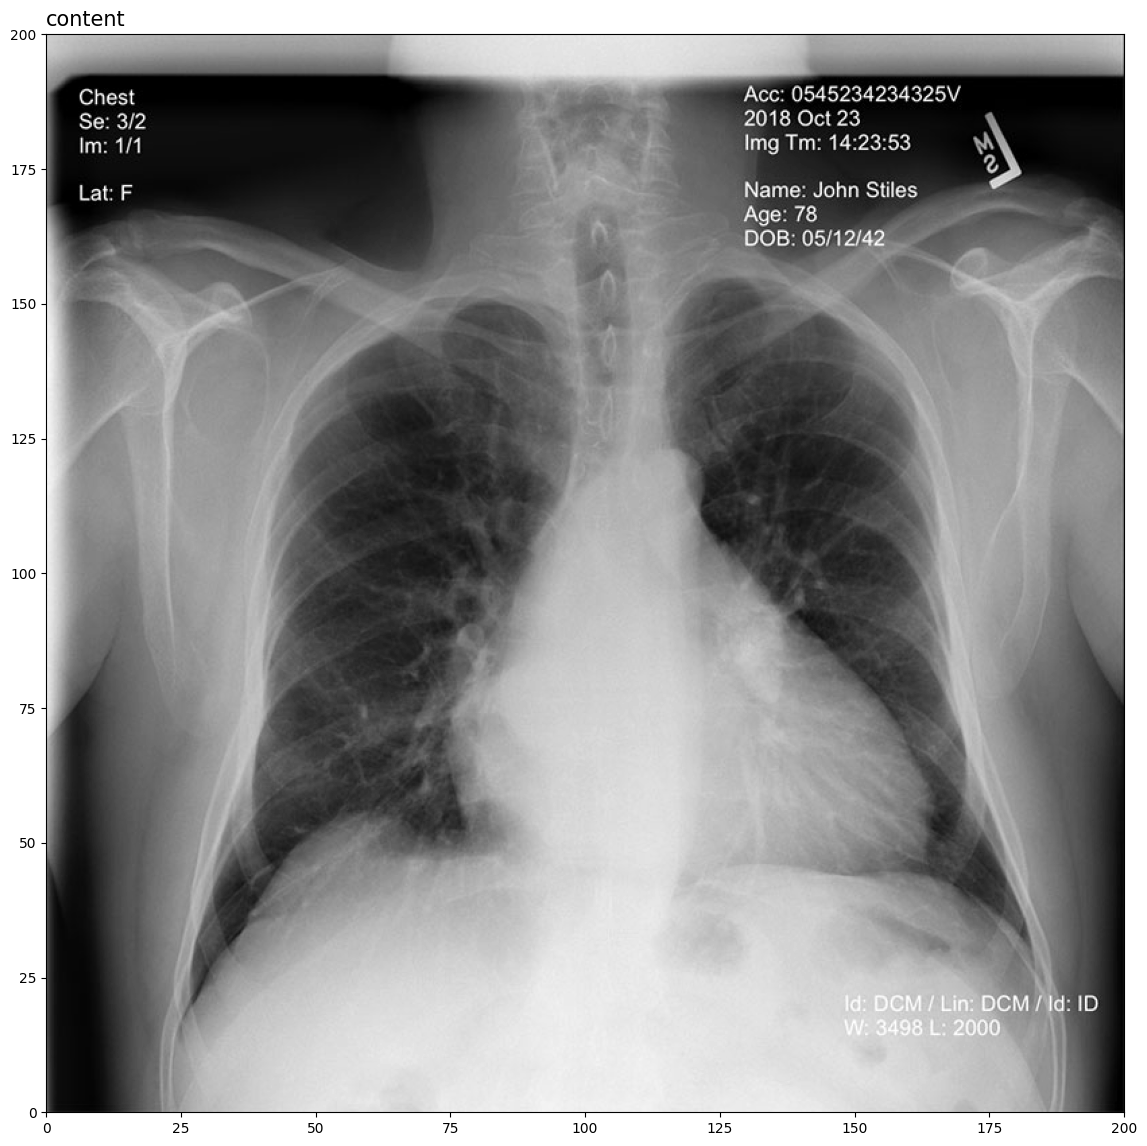

In [5]:
show_dicom(df, "content", show_meta=False)

## Run CleverDoc pipeline and display intermediate results

In [11]:
result = pipeline(True).transform(df).cache()

In [7]:
# Show detected text
print(result.select("text.text").collect()[0].text)

Chest
se: 3/2
Im: 1/1
Lat: F

ACC: 0545234234325V
2018 Oct 23
Img Tm: 14:23:53
Name: John Stiles
Age: 78
DOB: 05/12/42

1d DCM/Lin: DCM/ a 
wwa 3498 - 2000


In [8]:
# Show detected entities    
result.limit(1).select(f.explode("ner.entities").alias("entities")).select("entities.*").show(50)

+------------+------------------+--------------+-----+---+--------------------+
|entity_group|             score|          word|start|end|               boxes|
+------------+------------------+--------------+-----+---+--------------------+
|          ID| 0.995708703994751|0545234234325V|   35| 49|[{0545234234325V,...|
|        DATE|0.9835751056671143|           Oct|   55| 58|[{Oct, 0.99454885...|
|     PATIENT|  0.98607337474823|          John|   85| 89|[{John, 0.5720782...|
|     PATIENT|0.8783086538314819|        Stiles|   90| 96|[{Stiles, 0.99987...|
|         AGE|0.9990577101707458|            78|  102|104|[{78, 0.481130033...|
|        DATE|0.9997254014015198|            05|  110|112|[{05/12/42, 0.995...|
|        DATE|0.9995417594909668|            12|  113|115|[{05/12/42, 0.995...|
|        DATE|0.8975017666816711|            42|  116|118|[{05/12/42, 0.995...|
|       STAFF|0.9963669776916504|           Lin|  127|130|[{DCM/Lin:, 0.907...|
|       STAFF|0.9817715883255005|       

## Show original and de-identified DICOM

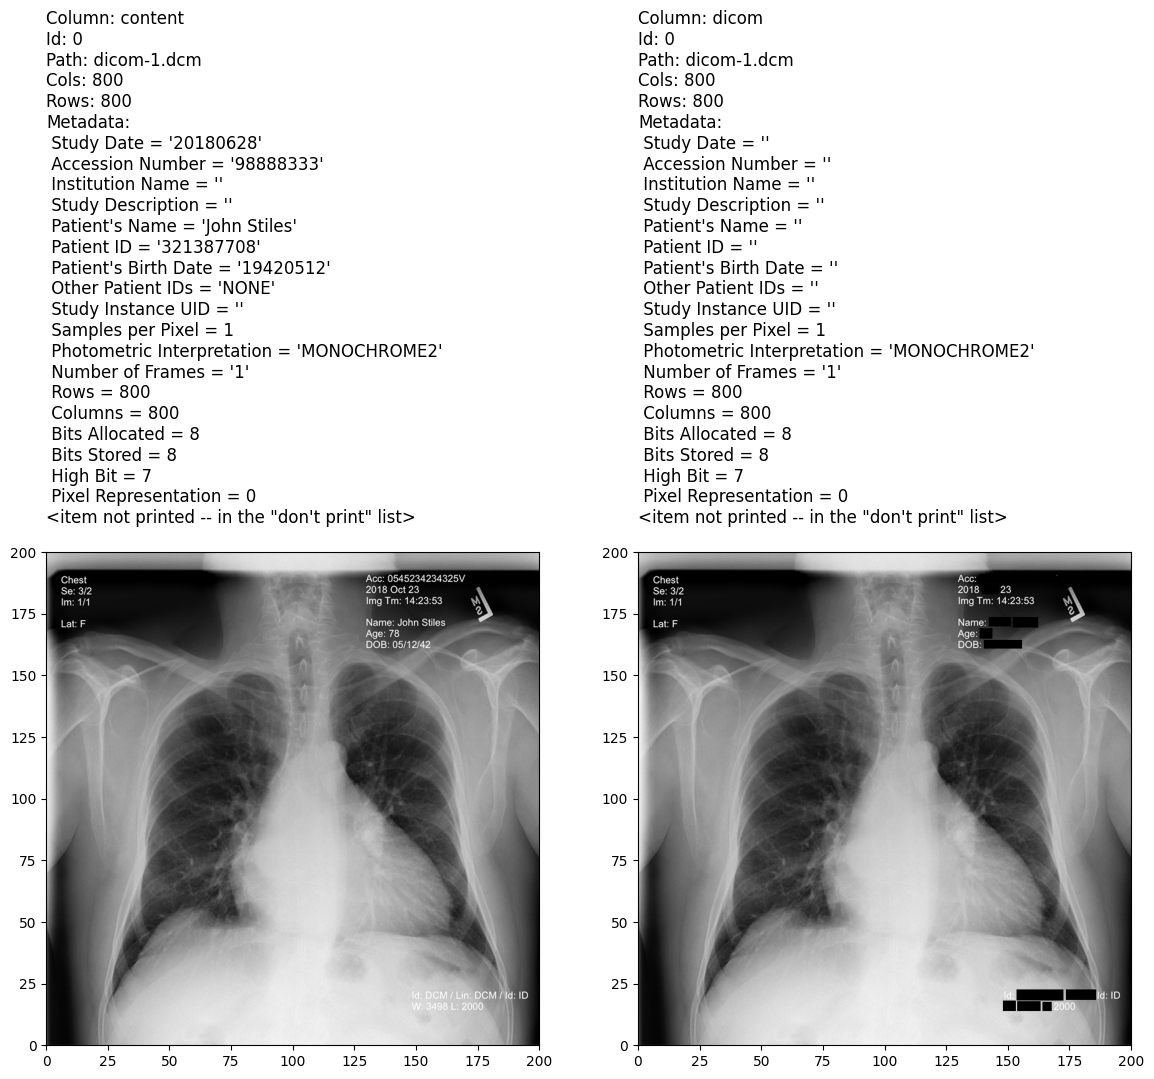

In [9]:
result = pipeline(False).transform(df).cache()
show_dicom(result, "content,dicom", show_meta=True)

## Save de-identified DICOM

In [10]:
result \
    .withColumn("fileName", get_name_udf(f.col("path"))) \
    .withColumn("dicom", f.col("dicom.data")) \
    .write \
    .format("pdfFormat") \
    .option("type", "dicom") \
    .option("field", "dicom") \
    .option("nameField", "fileName") \
    .option("extension", "dcm") \
    .option("prefix", "") \
    .mode("append") \
    .save("de-dicom")

## Check saved Dicom

In [12]:
!ls de-dicom

dicom-1.dcm  _SUCCESS


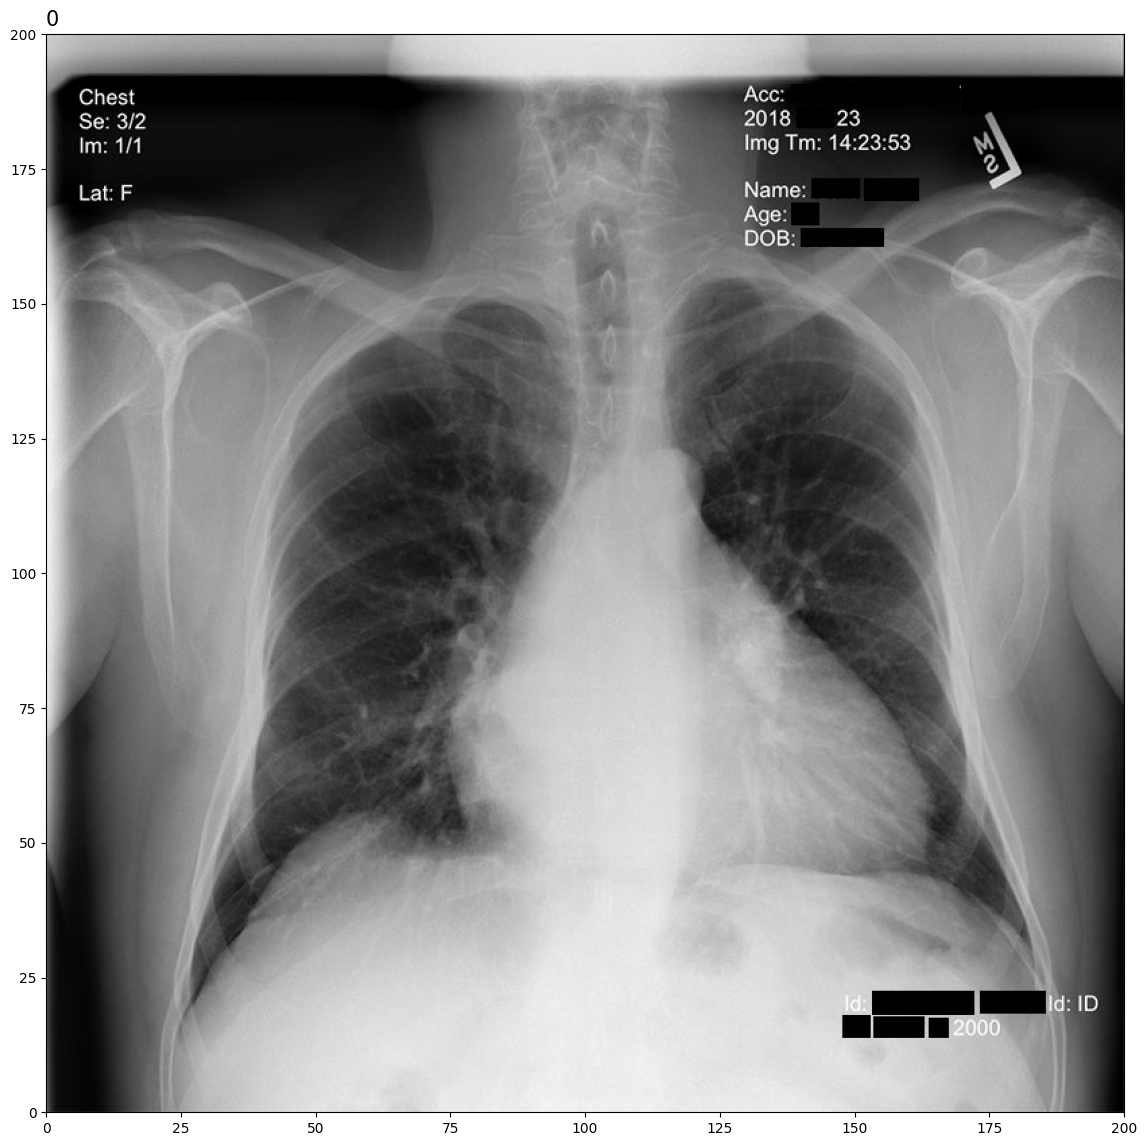

In [13]:
show_dicom("./de-dicom/dicom-1.dcm", "dicom", show_meta=False)